In [1]:
# Import all the libraries we'll need

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Make our plots look nice
plt.style.use('default')
sns.set_palette("husl")

# Polars display settings
pl.Config.set_tbl_width_chars(2000)   # make this large enough
pl.Config.set_tbl_cols(-1)           # -1 = show all columns

polars.config.Config

# Load Dataset

In [2]:
df = pl.read_csv("ncr_ride_bookings.csv", null_values=["", " ", "NA", "N/A", "NULL","null", "?"])

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")  # (rows, columns)
print(f"Total rides: {len(df):,}")

# Display first few rows
print(f"\n📋 Column Info:")
print(f"Total columns: {len(df.columns)}")

# Display first few rows
print(df.head())


Data loaded successfully!
Dataset shape: (150006, 21)
Total rides: 150,006

📋 Column Info:
Total columns: 21
shape: (5, 21)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method │
│ ---      ┆ ---      ┆ ---          ┆ ---             ┆ ---          ┆ 

#### Let's Explore our dataset first

In [3]:
print(df.describe()) # Display summary statistics

shape: (9, 22)
┌────────────┬──────────┬─────────┬──────────────┬───────────────────────┬──────────────┬──────────────┬─────────────────┬───────────────┬──────────┬───────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┐
│ statistic  ┆ Date     ┆ Time    ┆ Booking ID   ┆ Booking Status        ┆ Customer ID  ┆ Vehicle Type ┆ Pickup Location ┆ Drop Location ┆ Avg VTAT ┆ Avg CTAT  ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason     ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method │
│ ---        ┆ ---      ┆ ---     ┆ ---          ┆ ---                   ┆ ---          ┆ ---          ┆ ---             ┆ ---           ┆ ---      ┆ ---

### Summary of Missing Values

- Some columns have missing values, but these are **not errors or lost data**.  
- The missing values are natural and depend on the **booking situation**.  

#### Example: Null values when a ride is cancelled
The following columns are null if the ride was cancelled:  

- Avg CTAT  
- Incomplete Rides  
- Incomplete Rides Reason  
- Booking Value  
- Ride Distance  
- Driver Ratings  
- Customer Rating  
- Payment Method  

#### Mutually Exclusive Columns
Some columns cannot contain values at the same time because they are **conditionally dependent**:  

- *Cancelled Rides by Customer* & *Reason for Cancelling by Customer*  
- *Cancelled Rides by Driver* & *Driver Cancellation Reason*  
- *Incomplete Rides* & *Incomplete Rides Reason*  

**Why:** One column indicates **whether an event occurred**, and the other provides **context about that event**. If the event didn’t happen, the context column is naturally null.  

Thus, these missing values are **expected** in the dataset and arise logically from ride booking outcomes.


# Clean and prepare our Uber ride data for analysis

In [4]:
#checking for duplicate rows
dup_count = df.is_duplicated().sum()
print(f"Total duplicate rows: {dup_count}")

Total duplicate rows: 12


In [5]:
# Let's remove duplicate rows and keep the first occurrence only
df = df.unique(maintain_order=True)
print(f"Dataset shape after removing duplicates: {df.shape}")  # (rows, columns)
print(f"Total rides after removing duplicates: {len(df):,}")

Dataset shape after removing duplicates: (150000, 21)
Total rides after removing duplicates: 150,000


#### Converting Date and Time

In [6]:
df = df.with_columns([
    # Keep Date as string first (so concatenation works)
    pl.col("Date").alias("Date_str"),

    # Combine Date string and Time string, then parse as Datetime
    (pl.col("Date").alias("Date_str") + " " + pl.col("Time"))
    .str.strptime(pl.Datetime, "%d/%m/%y %H:%M:%S", strict=False)
    .alias("DateTime")
])
df = df.drop("Date_str")

print(df.head())

shape: (5, 22)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┬─────────────────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method ┆ DateTime            │
│ ---      ┆ ---      ┆ ---          ┆ ---             ┆ ---          ┆ ---           ┆ ---                 ┆ ---               ┆ ---    

#### Extracting time-related features

In [7]:
# Get hour, weekday number, month and weekend flag
df = df.with_columns([
    pl.col("DateTime").dt.hour().alias("Hour"),
    pl.col("DateTime").dt.weekday().alias("DayOfWeekNum"),  # 0=Monday
    pl.col("DateTime").dt.month().alias("Month"),
    (pl.col("DateTime").dt.weekday() >= 5).alias("IsWeekend")  # True if Sat/Sun
])

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

def map_weekday(x):
    if x is None or x < 1 or x > 7:  # 1–7 in your data
        return None
    return weekdays[x - 1]  # subtract 1 for 0-based list

# Create the DayOfWeek column safely
df = df.with_columns([
    pl.Series("DayOfWeek", [map_weekday(x) for x in df["DayOfWeekNum"]])
]).drop("DayOfWeekNum")


print(df.head())

shape: (5, 26)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┬─────────────────────┬──────┬───────┬───────────┬───────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method ┆ DateTime            ┆ Hour ┆ Month ┆ IsWeekend ┆ DayOfWeek │
│ ---      ┆ ---      ┆ ---          ┆ ---             ┆ --

#### Cleaning numeric columns

In [8]:
numeric_cols = ["Booking Value", "Ride Distance", "Driver Ratings", "Customer Rating"]
for col in numeric_cols:
    df = df.with_columns([
        pl.col(col).cast(pl.Float64)
        ])

print(df.head())

shape: (5, 26)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┬─────────────────────┬──────┬───────┬───────────┬───────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method ┆ DateTime            ┆ Hour ┆ Month ┆ IsWeekend ┆ DayOfWeek │
│ ---      ┆ ---      ┆ ---          ┆ ---             ┆ --

#### Creating some helpful flags

In [9]:
# Flag if the ride was successful or if customer/driver cancelled the ride

df = df.with_columns([
      (pl.col("Booking Status") == "Completed").alias("Is_Successful"),
      pl.col("Cancelled Rides by Customer").is_not_null().alias("Is_Cancelled_Customer"),
      pl.col("Cancelled Rides by Driver").is_not_null().alias("Is_Cancelled_Driver")
  ])

print(df.head())

shape: (5, 29)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┬─────────────────────┬──────┬───────┬───────────┬───────────┬───────────────┬───────────────────────┬─────────────────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method ┆ DateTime            ┆ Hour ┆ Month ┆ IsWeekend ┆ DayOfWeek

#### Categorizing Booking Status

In [10]:
df = df.with_columns([
    pl.when(pl.col("Booking Status") == "Completed").then(pl.lit("Completed"))
      .when(pl.col("Booking Status").str.contains("Cancelled")).then(pl.lit("Cancelled"))
      .when(pl.col("Booking Status") == "No Driver Found").then(pl.lit("No Driver Found"))
      .otherwise(pl.lit("Other"))
      .alias("Status_Category")
])


print(df.head())

shape: (5, 30)
┌──────────┬──────────┬──────────────┬─────────────────┬──────────────┬───────────────┬─────────────────────┬───────────────────┬──────────┬──────────┬─────────────────────────────┬─────────────────────────────────┬───────────────────────────┬────────────────────────────┬──────────────────┬─────────────────────────┬───────────────┬───────────────┬────────────────┬─────────────────┬────────────────┬─────────────────────┬──────┬───────┬───────────┬───────────┬───────────────┬───────────────────────┬─────────────────────┬─────────────────┐
│ Date     ┆ Time     ┆ Booking ID   ┆ Booking Status  ┆ Customer ID  ┆ Vehicle Type  ┆ Pickup Location     ┆ Drop Location     ┆ Avg VTAT ┆ Avg CTAT ┆ Cancelled Rides by Customer ┆ Reason for cancelling by Custo… ┆ Cancelled Rides by Driver ┆ Driver Cancellation Reason ┆ Incomplete Rides ┆ Incomplete Rides Reason ┆ Booking Value ┆ Ride Distance ┆ Driver Ratings ┆ Customer Rating ┆ Payment Method ┆ DateTime            ┆ Hour ┆ Month ┆ IsW

# Let's generate some key buisness metrics

In [11]:
# Total rides
total_rides = df.height  
print(f"📊  Total rides: {total_rides:,}")

# Successful rides
successful_rides = df.filter(pl.col("Is_Successful")).height
print(f"✅ Successful Rides: {successful_rides}")

success_rate = (successful_rides / total_rides) * 100
print(f"📈 Success Rate: {success_rate}")

# Revenue & ride stats for successful rides
successful_df = df.filter(pl.col("Is_Successful"))

total_revenue = successful_df["Booking Value"].sum()
print(f"💰 Total revenue from successful rides: ₹{total_revenue:,.2f}")

avg_ride_value = successful_df["Booking Value"].mean()
print(f"💵 Average ride value: ₹{avg_ride_value:,.2f}")

avg_distance = successful_df["Ride Distance"].mean()
print(f"🛣️ Average ride distance: {avg_distance:.2f} km")

avg_driver_rating = successful_df["Driver Ratings"].mean()
print(f"⭐ Average driver rating: {avg_driver_rating:.2f} \ 5.0")

avg_customer_rating = successful_df["Customer Rating"].mean()
print(f"⭐ Average customer rating: {avg_customer_rating:.2f} \ 5.0")


# Cancellations
customer_cancellations = df["Is_Cancelled_Customer"].sum()
print(f"❌ Total customer cancellations: {customer_cancellations:,}")

driver_cancellations = df["Is_Cancelled_Driver"].sum()
print(f"🚫 Total driver cancellations: {driver_cancellations:,}")



📊  Total rides: 150,000
✅ Successful Rides: 93000
📈 Success Rate: 62.0
💰 Total revenue from successful rides: ₹47,260,574.00
💵 Average ride value: ₹508.18
🛣️ Average ride distance: 26.00 km
⭐ Average driver rating: 4.23 \ 5.0
⭐ Average customer rating: 4.40 \ 5.0
❌ Total customer cancellations: 10,500
🚫 Total driver cancellations: 27,000


# Let's visualise what makes a ride successful

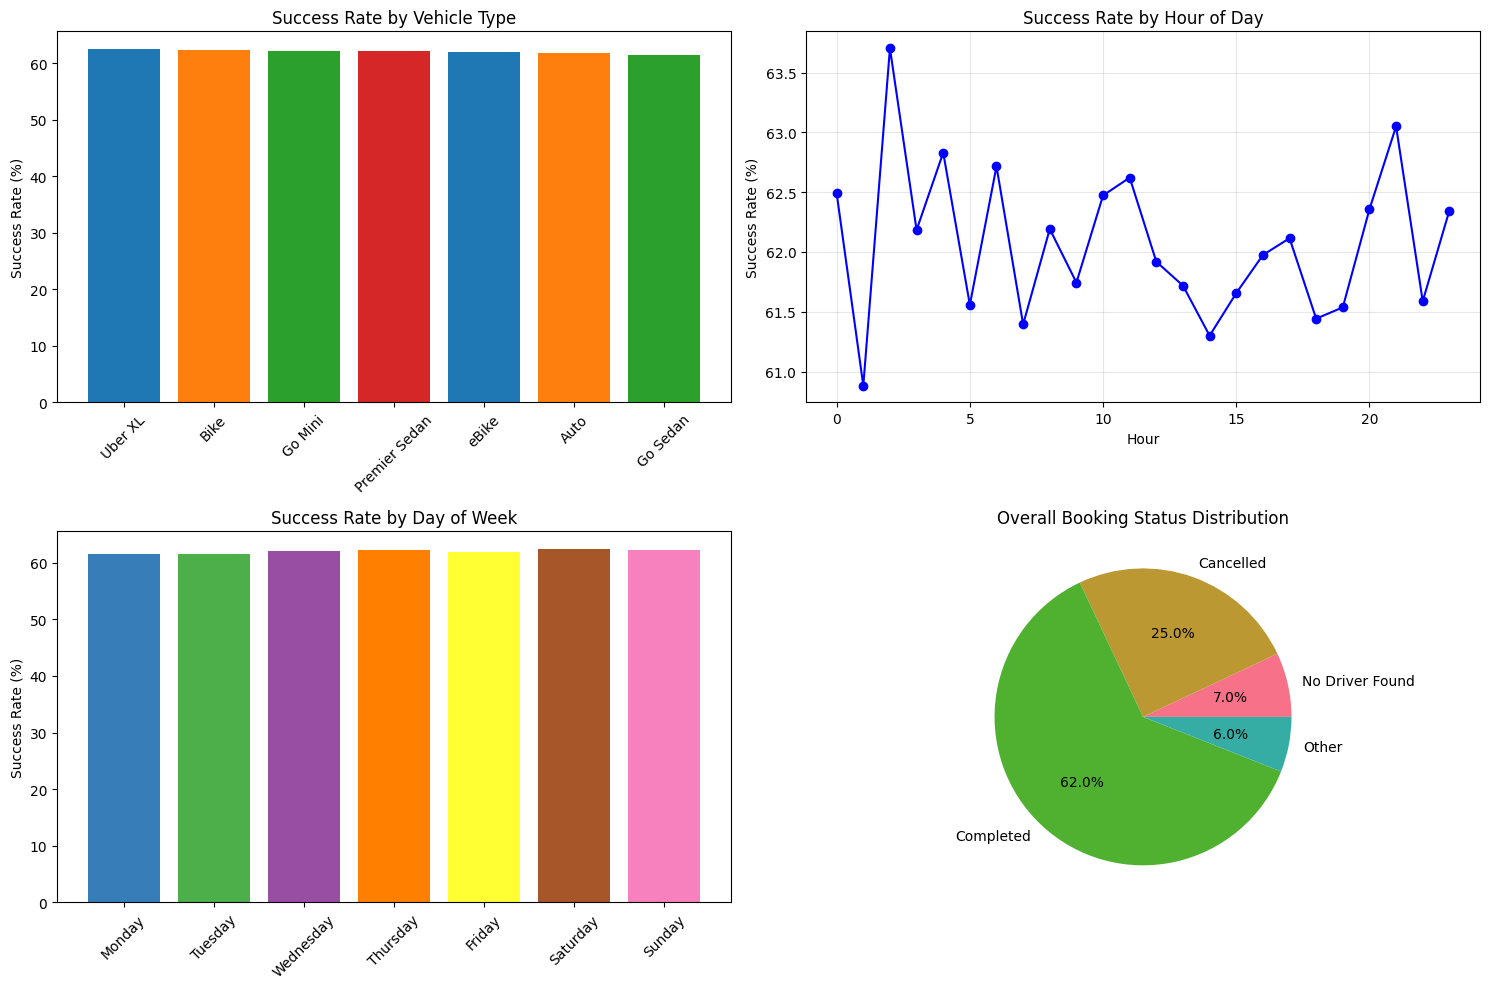

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Success rate by Vehicle Type
vehicle_types = df["Vehicle Type"].unique()
vehicle_success_data = []

for vt in vehicle_types:
    vt_df = df.filter(pl.col("Vehicle Type") == vt)
    total = vt_df.height
    success = vt_df.filter(pl.col("Is_Successful")).height
    rate = success / total if total > 0 else 0
    vehicle_success_data.append((vt, total, success, rate))


vehicle_success = pd.DataFrame(vehicle_success_data, columns=["Vehicle Type", "Total_Rides", "Successful_Rides", "Success_Rate"])
vehicle_success = vehicle_success.sort_values("Success_Rate", ascending=False)

# Plotting it
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # as many as needed
axes[0, 0].bar(vehicle_success["Vehicle Type"], vehicle_success["Success_Rate"] * 100, color=colors)
axes[0, 0].set_title("Success Rate by Vehicle Type")
axes[0, 0].set_ylabel("Success Rate (%)")
axes[0, 0].tick_params(axis="x", rotation=45)


# Success rate by Hour
hours = sorted(df["Hour"].unique())
hourly_success_data = []

for h in hours:
    h_df = df.filter(pl.col("Hour") == h)
    total = h_df.height
    success = h_df.filter(pl.col("Is_Successful")).height
    rate = success / total if total > 0 else 0
    hourly_success_data.append((h, total, success, rate))

hourly_success = pd.DataFrame(hourly_success_data, columns=["Hour", "Total_Rides", "Successful_Rides", "Success_Rate"])

# Plotting it
axes[0, 1].plot(hourly_success["Hour"], hourly_success["Success_Rate"] * 100, marker="o", color="blue")
axes[0, 1].set_title("Success Rate by Hour of Day")
axes[0, 1].set_xlabel("Hour")
axes[0, 1].set_ylabel("Success Rate (%)")
axes[0, 1].grid(True, alpha=0.3)


# Success rate by Day of Week
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_success_data = []

for day in days:
    day_df = df.filter(pl.col("DayOfWeek") == day)
    total = day_df.height
    success = day_df.filter(pl.col("Is_Successful")).height
    rate = success / total if total > 0 else 0
    daily_success_data.append((day, total, success, rate))

daily_success = pd.DataFrame(daily_success_data, columns=["DayOfWeek", "Total_Rides", "Successful_Rides", "Success_Rate"])

# Plotting it
colors = [ "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]
axes[1, 0].bar(daily_success["DayOfWeek"], daily_success["Success_Rate"] * 100, color=colors)
axes[1, 0].set_title("Success Rate by Day of Week")
axes[1, 0].set_ylabel("Success Rate (%)")
axes[1, 0].tick_params(axis="x", rotation=45)


# Booking status distribution
status_categories = df["Status_Category"].unique()
status_counts_data = []

for status in status_categories:
    count = df.filter(pl.col("Status_Category") == status).height
    status_counts_data.append((status, count))

status_counts = pd.DataFrame(status_counts_data, columns=["Status_Category", "Count"])

# Plotting it
axes[1, 1].pie(status_counts["Count"], labels=status_counts["Status_Category"], autopct="%1.1f%%")
axes[1, 1].set_title("Overall Booking Status Distribution")
plt.tight_layout()
plt.show()

- The analysis reveals that success rates are highly consistent across all vehicle types, with Uber XL, Bike, and Go Mini showing the highest—though only marginally better—performance. 
- Completion rates for bookings are strong at 62%, with cancellations accounting for 25%. 
- Time of day and day of week have minimal impact on booking success rates, indicating stable performance throughout.

# Revenue Patterns

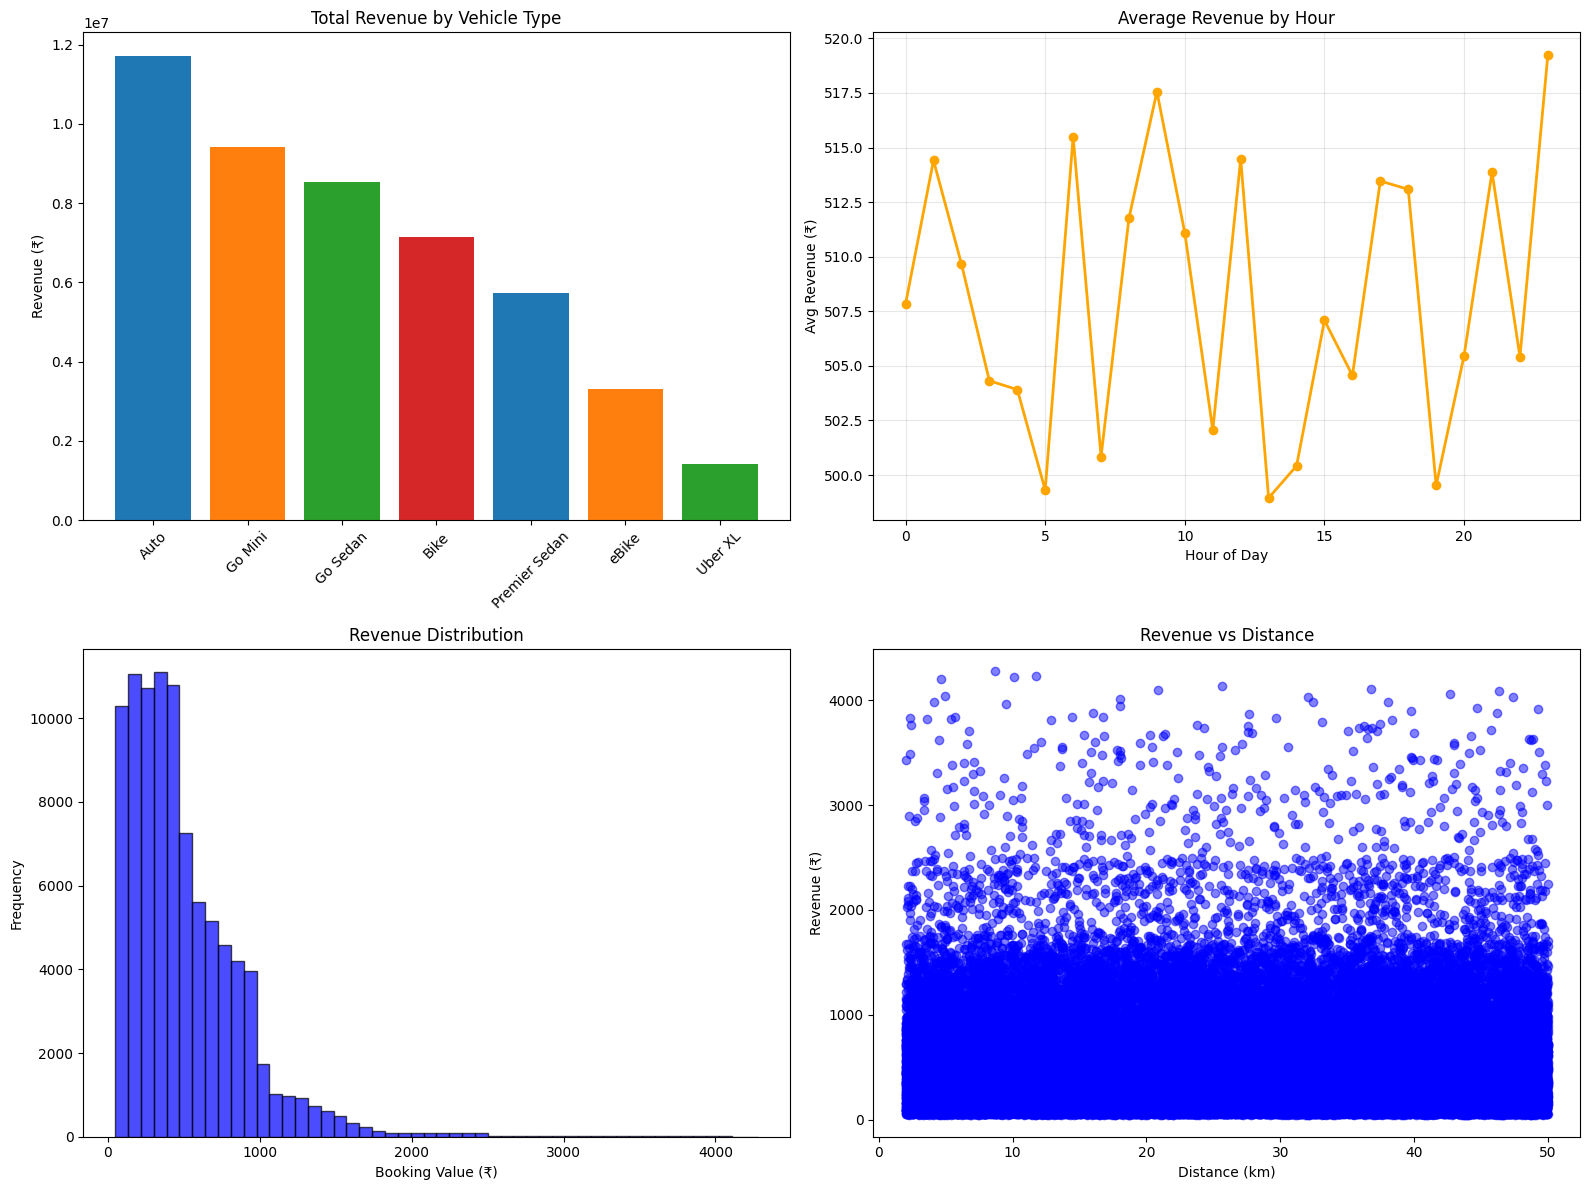

In [13]:
# Prepare successful rides
successful_rides = df.filter(pl.col("Is_Successful"))

# Revenue by Vehicle Type
vehicle_types = df["Vehicle Type"].unique()
vehicle_revenue_data = []

for vt in vehicle_types:
    vt_df = successful_rides.filter(pl.col("Vehicle Type") == vt)
    total_rides = vt_df.height
    total_revenue = vt_df["Booking Value"].sum() if total_rides > 0 else 0
    avg_revenue = vt_df["Booking Value"].mean() if total_rides > 0 else 0
    vehicle_revenue_data.append((vt, total_rides, total_revenue, avg_revenue))

total_revenue_all = sum(x[2] for x in vehicle_revenue_data)
vehicle_revenue_data = [
    (vt, tr, rev, avg, (rev / total_revenue_all * 100 if total_revenue_all > 0 else 0))
    for vt, tr, rev, avg in vehicle_revenue_data
]

vehicle_revenue = pd.DataFrame(
    vehicle_revenue_data,
    columns=["Vehicle Type", "Ride_Count", "Total_Revenue", "Avg_Revenue", "Revenue_Share"]
).sort_values("Revenue_Share", ascending=False)


# Revenue by Hour
hours = range(24)
hourly_revenue_data = []

for h in hours:
    h_df = successful_rides.filter(pl.col("Hour") == h)
    avg_revenue = h_df["Booking Value"].mean() if h_df.height > 0 else 0
    hourly_revenue_data.append((h, avg_revenue))

hourly_revenue = pd.DataFrame(hourly_revenue_data, columns=["Hour", "Avg_Revenue"])

# Revenue Distribution
revenue_values = successful_rides["Booking Value"].to_list()

# Revenue vs Distance
distance_values = successful_rides["Ride Distance"].to_list()
revenue_vs_distance = successful_rides["Booking Value"].to_list()


# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total Revenue by Vehicle Type
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
axes[0,0].bar(vehicle_revenue["Vehicle Type"], vehicle_revenue["Total_Revenue"], color=colors)
axes[0,0].set_title("Total Revenue by Vehicle Type")
axes[0,0].set_ylabel("Revenue (₹)")
axes[0,0].tick_params(axis="x", rotation=45)

# Average Revenue by Hour
axes[0,1].plot(hourly_revenue["Hour"], hourly_revenue["Avg_Revenue"], marker='o', color= "orange", linewidth=2)
axes[0,1].set_title("Average Revenue by Hour")
axes[0,1].set_xlabel("Hour of Day")
axes[0,1].set_ylabel("Avg Revenue (₹)")
axes[0,1].grid(True, alpha=0.3)

# Revenue Distribution
axes[1,0].hist(revenue_values, bins=50, alpha=0.7, color= "blue", edgecolor='black')
axes[1,0].set_title("Revenue Distribution")
axes[1,0].set_xlabel("Booking Value (₹)")
axes[1,0].set_ylabel("Frequency")

# Revenue vs Distance
axes[1,1].scatter(distance_values, revenue_vs_distance, alpha=0.5, color= "blue")
axes[1,1].set_title("Revenue vs Distance")
axes[1,1].set_xlabel("Distance (km)")
axes[1,1].set_ylabel("Revenue (₹)")

plt.tight_layout()
plt.show()



- Auto generates the highest total revenue among all vehicle types, followed by Go Mini and Go Sedan, while Uber XL brings in the least.
- The average revenue per hour doesn’t change much throughout the day, staying mostly between ₹500 and ₹520, which means there aren’t any big peaks or drops in hourly earnings.
- Most individual bookings have lower values, as seen in the revenue distribution histogram, and high-value bookings are much less common.
- The revenue vs distance scatter plot shows that for any given distance, the revenue can vary a lot, so trip distance alone isn’t a strong predictor of revenue.


# ML Model for Revenue Prediction

#### Filter for successful rides with booking value

In [14]:
df_revenue_model = df.filter((pl.col("Is_Successful") == True) & pl.col("Booking Value").is_not_null())
n_samples = df_revenue_model.height

print(f"Training samples: {n_samples}")

Training samples: 93000


#### Create cyclical features for time (Cyclic Encoding)

In [15]:
df_model_features = df_revenue_model.with_columns([
    pl.col("Hour").map_elements(lambda x: np.sin(2 * np.pi * x / 24), return_dtype=pl.Float64).alias("Hour_Sin"),
    pl.col("Hour").map_elements(lambda x: np.cos(2 * np.pi * x / 24), return_dtype=pl.Float64).alias("Hour_Cos"),
    pl.col("Month").map_elements(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("Month_Sin"),
    pl.col("Month").map_elements(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("Month_Cos"),
    pl.col("IsWeekend").cast(pl.Int64).alias("IsWeekend_Numeric")
])

#### Encode categorical variables

In [16]:
le_vehicle = LabelEncoder()
df_model_features = df_model_features.with_columns([
    pl.Series("Vehicle_Type_Encoded", le_vehicle.fit_transform(df_model_features["Vehicle Type"].to_list())),
    pl.Series("Pickup_Encoded", LabelEncoder().fit_transform(df_model_features["Pickup Location"].to_list())),
    pl.Series("Drop_Encoded", LabelEncoder().fit_transform(df_model_features["Drop Location"].to_list()))
])

#### Selecting features for model

In [17]:
feature_columns = [
        "Hour_Sin", "Hour_Cos", "Month_Sin", "Month_Cos",
        "IsWeekend_Numeric", "Vehicle_Type_Encoded",
        "Pickup_Encoded", "Drop_Encoded"
    ]

X = df_model_features.select(feature_columns).to_pandas()
y = df_model_features["Booking Value"].to_pandas()

#### Train/Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number Training Samples:", len(X_train))
print("Number Testing Samples:", len(X_test))

Number Training Samples: 74400
Number Testing Samples: 18600


#### Random Forest Regressor

Revenue Prediction R² Score: -0.044
Revenue Prediction RMSE: ₹408.16


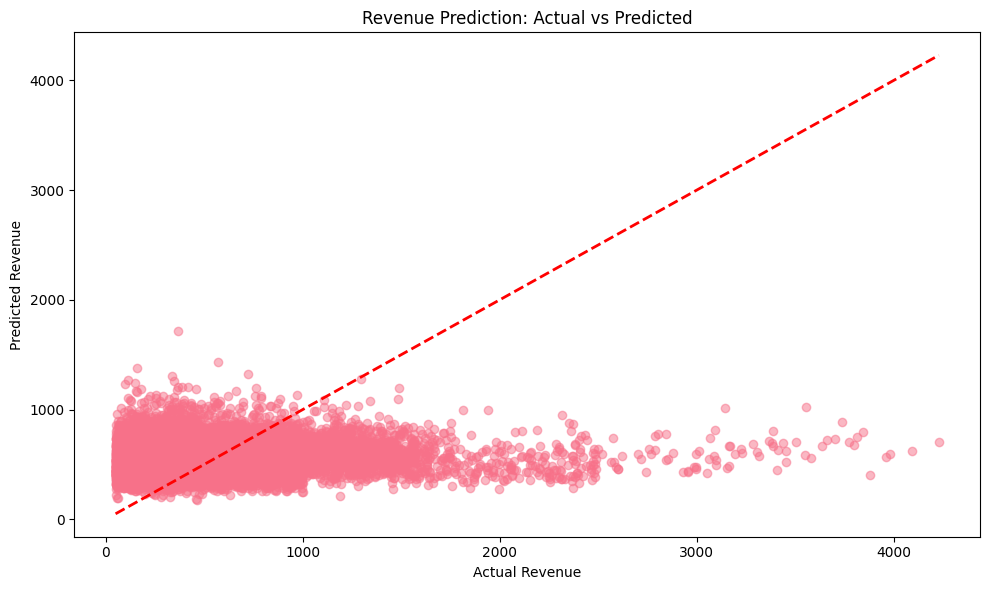

In [25]:
rf_revenue = RandomForestRegressor(n_estimators=100, random_state=42)
rf_revenue.fit(X_train, y_train)

# Predictions and metrics
y_pred = rf_revenue.predict(X_test)
rev_r2 = r2_score(y_test, y_pred)
rev_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Revenue Prediction R² Score: {rev_r2:.3f}")
print(f"Revenue Prediction RMSE: ₹{rev_rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Revenue Prediction: Actual vs Predicted')
plt.tight_layout()
plt.show()

#### Feature importance

In [27]:
revenue_feature_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": rf_revenue.feature_importances_
}).sort_values("Importance", ascending=False)

print("TOP FEATURES FOR REVENUE PREDICTION:")
print(revenue_feature_importance)

TOP FEATURES FOR REVENUE PREDICTION:
                Feature  Importance
6        Pickup_Encoded    0.276746
7          Drop_Encoded    0.270331
5  Vehicle_Type_Encoded    0.101112
0              Hour_Sin    0.090034
1              Hour_Cos    0.089057
2             Month_Sin    0.070098
3             Month_Cos    0.069545
4     IsWeekend_Numeric    0.033078
